In [60]:
# Block 1: Data generation
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
l = 1000 # 1000 time steps
t = np.linspace(0, 100, l) # a time interval of 100 seconds
a = np.zeros(1000) # initialize accelaration
v = np.zeros(1000) # initialize velocity
s = np.zeros(1000) # initialize position
variance_Zs = 0.1 # variance of system error with respect to position
variance_Zv = 0.01  # variance of system error with respect to velocity
variance_Za = 0.001 # variance of system error with respect to acceleration
variance_Ms = 20 # /sigma_Ms^2 = 20 # variance of measurement error with respect to position
variance_Mv = 5 # /sigma_Ms^2 = 2 # variance of measurement error with respect to velocity
#variance_Ma = 0.0001 # /sigma_Ma^2 =0.2 # variance of measurement error with respect to acceleration
noise_Zs = np.random.normal(0,variance_Zs,1000)
noise_Zv = np.random.normal(0,variance_Zv,1000) 
noise_Za = np.random.normal(0,variance_Za,1000) 
noise_Ms = np.random.normal(0,variance_Ms,1000)  
noise_Mv = np.random.normal(0,variance_Mv,1000)
#noise_Ma = np.random.normal(0,variance_Ma,1000)
Ts = 100/l
# x_k+1 = Ad * x_k + Bd * u_k + Gd * z_k
# y_k = C * x_k + w_k
Ad = np.matrix([[1,Ts,0.5*(Ts*Ts)],
                  [0,1,Ts],
                  [0,0,0]]) ##  0,0,0 for the simulation of real physical system
Bd = np.array ([0.5*(Ts*Ts),Ts,1]).reshape(-1,1)
u = np.zeros((1,1000))
u[:,200:225] = -10 # step function
Gd = np.matrix ([[1,0,0],[0,1,0],[0,0,1]])
C = np.matrix ([[1,0,0],[0,1,0]]) # we only measure position and velocity
#D = np.array ([0,0,1]).reshape(-1,1) #we do not include control input in the measurement
Md = np.matrix ([[1,0],[0,1]])

#noise matrix
z = np.vstack((noise_Zs,noise_Zv,noise_Za))
w = np.vstack((noise_Ms,noise_Mv))

#initiallize
StateMatrix = np.zeros((3,1000))
MeasurementMatrix = np.zeros((2,1000))
v[0] = 50 #initial velocity
x = np.array ([[s[0]],[v[0]],[a[0]]])

y = np.array ([0,0])
z_0 = z[:,0].reshape (3,1)
w_0 = w[:,0].reshape (2,1)

StateMatrix[:,0] = np.squeeze(x)
MeasurementMatrix[:,0] = np.squeeze(y)
for k in range(0, len(t)):
      z_k = z[:,k].reshape (3,1)
      w_k = w[:,k].reshape (2,1)
      u_k = u[:,k].reshape (1,1)
      x = Ad * x + Bd * u_k + Gd * z_k
      y = C * x + Md * w_k
      StateMatrix[:,k] = np.squeeze(x)
      MeasurementMatrix[:,k] = np.squeeze(y)

In [61]:
# Block 2: Kalman filter implementation version 2.1

#Split the measured data into 100 batches
batch_size = 10
num_batches = len(t)//batch_size # 

#initialize lists to store results:
P_list = []
P_pred_list = []
smoothed_list = []

for batch_idx in range (num_batches):
    #define time indices
    start_idx = batch_idx *batch_size # 0=0*10, 10= 1*10, first batch: 0-9, second batch: 10-19
    end_idx = (batch_idx + 1) *batch_size

    #extract measurement data
    z_batch = z[:,start_idx:end_idx] # !!! z is the measurement matrix for a small batch

    #initialize state estimate and error covariance matrix for current batch
    x_hat_batch = np.zeros((3,1))
    P_ini = np.diag([1000, 1000, 1000])
    P_batch = P_ini
    #P_batch = np.diag([1000, 1000, 1000])

    # Initialize lists to store intermediate results for current batch
    x_hat_pred_list = []
    P_pred_list = []
    K_list = [] # !!! if it is necessary?

    # Initialize matrix to store state estimates for this batch
    state_estimate_batch = np.zeros((3, batch_size))

    for k in range(start_idx, end_idx):

        # define the parameters that are able to be tuned
        Q = np.diag([0.001, 0.001, 0.001]) 
        R = np.diag([50, 10])

        # define the prediction model
            # x_pred = Ad_f * x + Gd_f * z
            # y = C_f * x + Md_f * w
        Ad_f = np.matrix([[1,Ts,0.5*(Ts*Ts)], # The Ad_f is the stat transition matrix that we use as prediction in the filter
                    [0,1,Ts],
                   [0,0,1]]) ## Ad_f should be 0,0,1 (assume cosntant acceleration) because we do not know the real dynamics of the object vehicle
        Gd_f = Gd
        C_f = C
        Md_f = Md 

        # Prediction step
        x_hat_pred = Ad_f.dot(x_hat_batch)
        P_pred = Ad_f.dot(P_batch).dot(Ad_f.T) + Gd_f.dot(Q).dot(Gd_f.T)

        # Save intermediate results
        x_hat_pred_list.append(x_hat_pred) # half-necessary
        P_pred_list.append(P_pred) # half-necessary

        # Update step
        y = z_batch[:, k - start_idx].reshape(-1, 1) #extract measurement from the (k - start_idx)th time step within this batch
        S = C_f.dot(P_pred).dot(C_f.T) + Md_f.dot(R).dot(Md_f.T)
        K = P_pred.dot(C_f.T).dot(np.linalg.pinv(S)) 
        x_hat = x_hat_pred + K.dot(y - C_f.dot(x_hat_pred))
        P = (np.eye(3) - K.dot(C_f)).dot(P_pred) #

        # Save state estimate for this timestep
        state_estimate_batch[:,k] = np.squeeze(x_hat)

        # Save intermediate results
        K_list.append(K) # necessary?

        # Save current state estimate and error covariance matrix for next timestep
        x_hat_batch = x_hat
        P_batch = P

    # Save P and P_pred lists for this batch
    P_list.append(P_batch_list)
    P_pred_list.append(P_pred_batch_list)   

    # Initialize matrix to store smoothed state estimates for this batch
    smoothed_batch = np.zeros((3, batch_size))

    # Apply RTS smoother to get smoothed signal for current batch
    smoothed_batch = np.zeros((3, batch_size))
    smoothed_batch[:, -1] = x_hat_batch.flatten()
    for k in range(batch_size - 2, -1, -1): # k from -1 to 8, in total 10, starting from k = 8
        smoothed_batch[:, k] = x_hat_pred_list[k] + P_pred_list[k].dot(
            np.linalg.inv(P_list[k + 1]).dot(smoothed_batch[:, k + 1] - x_hat_pred_list[k + 1])
        )

    # Save results for current batch
    P_list.append(P_batch)
    P_pred_list.append(P_pred)
    smoothed_list.append(smoothed_batch)

# Concatenate smoothed signals for all batches
smoothed = np.concatenate(smoothed_list, axis=1)

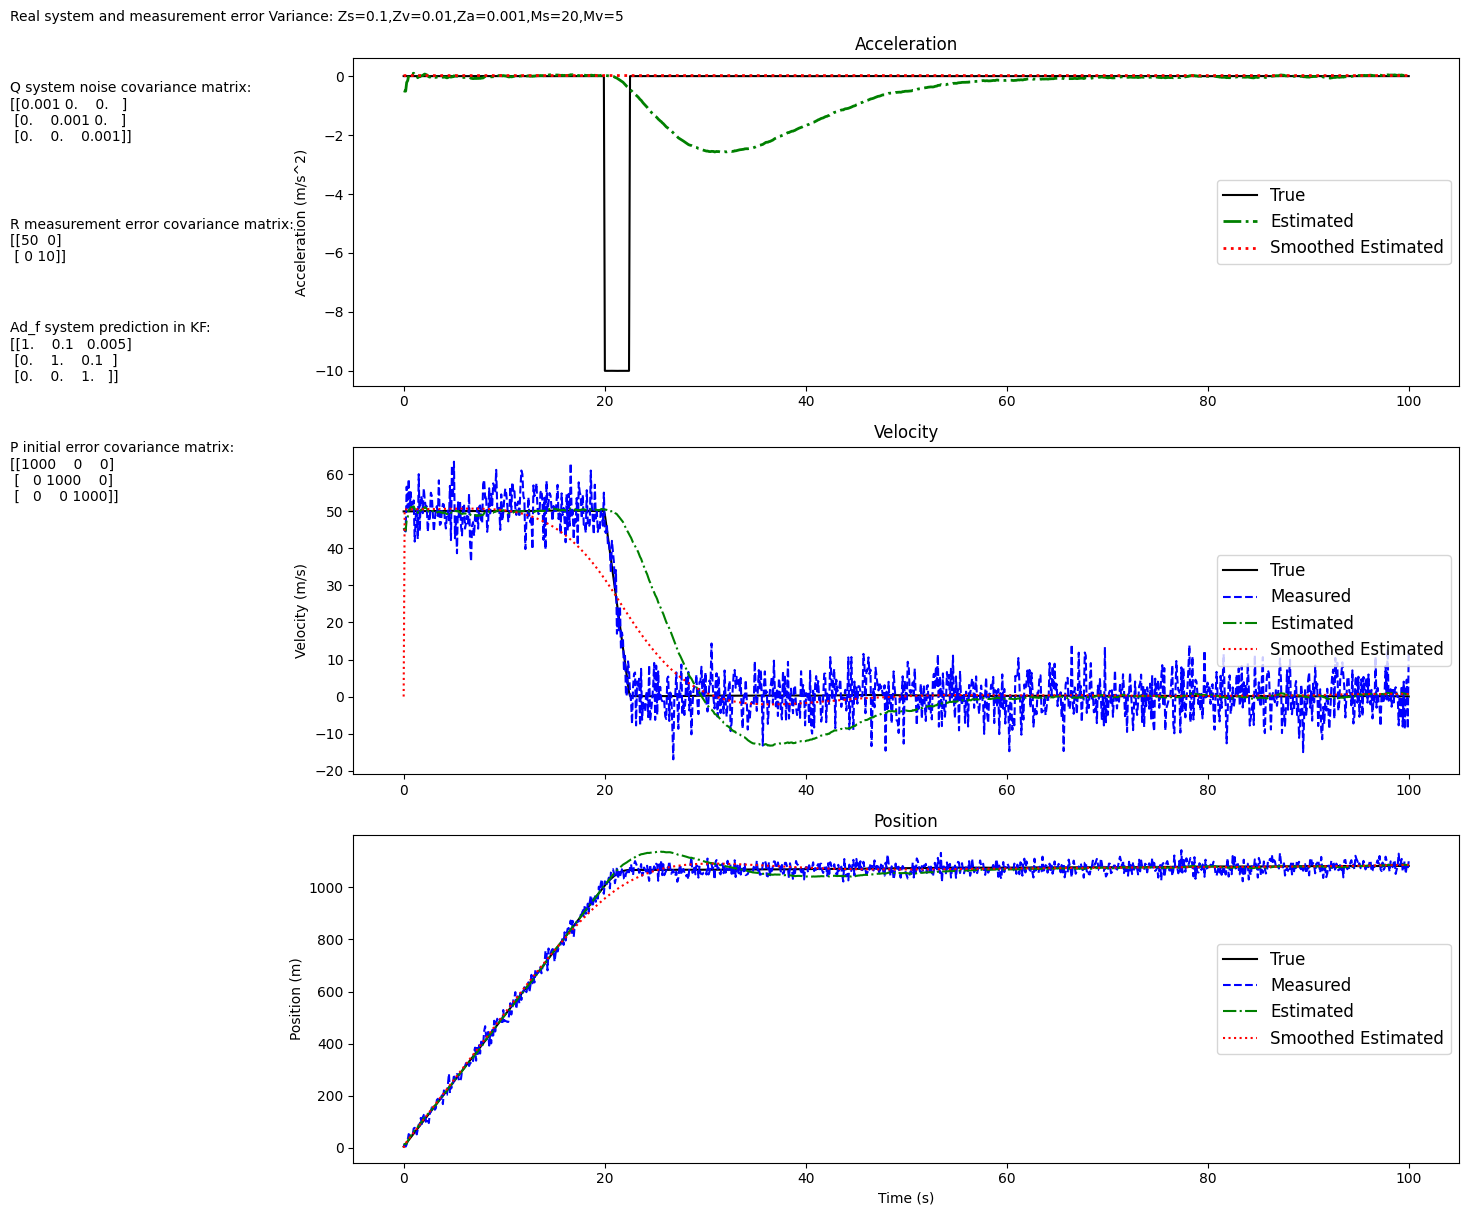

In [62]:
import matplotlib.pyplot as plt

# Plotting the true, measured, and estimated position
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

fig.text(-0.22,1, f'Real system and measurement error Variance: Zs={variance_Zs},Zv={variance_Zv},Za={variance_Za},Ms={variance_Ms},Mv={variance_Mv}',fontsize=10, ha='left')
fig.text(-0.22,0.9, f'Q system noise covariance matrix:\n{Q}',fontsize=10, ha='left')
fig.text(-0.22,0.8, f'R measurement error covariance matrix:\n{R}',fontsize=10, ha='left')
fig.text(-0.22,0.7, f'Ad_f system prediction in KF:\n{Ad_f}',fontsize=10, ha='left')
fig.text(-0.22,0.6, f'P initial error covariance matrix:\n{P_ini}',fontsize=10, ha='left')

# Plot acceleration
ax[0].plot(t, StateMatrix[2,:], 'k-', label='True')
ax[0].plot(t, StateEstimate[2,:], 'g-.', label='Estimated', linewidth=2)
ax[0].plot(t, SmoothedEstimate[2,:], 'r:', label='Smoothed Estimated',linewidth=2)
ax[0].set_ylabel('Acceleration (m/s^2)')
ax[0].set_title('Acceleration')
ax[0].legend(loc='center right', fontsize=12)

# Plot velocity
ax[1].plot(t, StateMatrix[1,:], 'k-', label='True')
ax[1].plot(t, MeasurementMatrix[1,:], 'b--', label='Measured')
ax[1].plot(t, StateEstimate[1,:], 'g-.', label='Estimated')
ax[1].plot(t, SmoothedEstimate[1,:], 'r:', label='Smoothed Estimated')
ax[1].set_ylabel('Velocity (m/s)')
ax[1].set_title('Velocity')
ax[1].legend(loc='center right', fontsize=12)
# Plot position
ax[2].plot(t, StateMatrix[0,:], 'k-', label='True')
ax[2].plot(t, MeasurementMatrix[0,:], 'b--', label='Measured')
ax[2].plot(t, StateEstimate[0,:], 'g-.', label='Estimated')
ax[2].plot(t, SmoothedEstimate[0,:], 'r:', label='Smoothed Estimated')
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Position (m)')
ax[2].set_title('Position')
ax[2].legend(loc='center right', fontsize=12)
plt.tight_layout()
plt.show()